In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import time
import pickle
import os

import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score

import random, os, json
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, GRU, Dropout, Dense
from tensorflow.keras import backend as K


import sys
sys.path.append("../")
import methods
import utils_models 
import utils_interpretability


from joblib import Parallel, delayed
import multiprocessing

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


# FUNCTIONS OF THE MODEL

In [2]:
def create_temp_weight_mod(y, hyperparameters, timeSteps=14):
    """
    Create temporary weights based on class imbalance in the data, based on the frequency of AMR and non-AMR over time.

    Args:
    - y: A DataFrame containing the target variable and additional columns 'Admissiondboid' and 'dayToDone'.
    - hyperparameters: A dictionary containing the model's hyperparameters.
    - timeSteps: An integer representing the number of time steps.
    Returns:
    - A 3D numpy array with the calculated weights as (samples, timeSteps, 1).
    """
   
    df_imbalance = y
    df_imbalance = df_imbalance[df_imbalance.individualMRGerm != hyperparameters["mask_value"]][["dayToDone", "individualMRGerm"]]
    arr_imbalance = df_imbalance.groupby("dayToDone").mean().values
    
    # Invert frequencies to obtain penalty
    arr_penalty_positives = 1 / arr_imbalance
    arr_penalty_negatives = 1 / (1 - arr_imbalance)

    # Apply adjustment factor
    arr_penalty_positives *= hyperparameters['adjustment_factor']
    
    y_func = y.loc[:, 'individualMRGerm'].values.reshape(y.shape[0] // timeSteps, timeSteps, 1)
    
    weights = np.ones(y_func.shape)
    for t in range(timeSteps):
        weights[:, t, :] = np.where(y_func[:, t, :] == 1, arr_penalty_positives[t], arr_penalty_negatives[t])
    weights = np.where(y_func == hyperparameters["mask_value"], 0, weights)
        
    return weights

In [3]:
def build_model(hyperparameters):
    """
    Builds a GRU model with Hadamard attention based on several hyperparameters.

    Args:
        - hyperparameters: Dictionary containing the hyperparameters. 
    Returns:
        - model: A tf.keras.Model with the compiled model.
        - hadamard_scores: A tf.Tensor with the attention scores.
        - dynamic_input: A tf.Tensor with the input layer.
    """
    dynamic_input = tf.keras.layers.Input(shape=(hyperparameters["n_time_steps"], hyperparameters["layers"][0]))
    masked = tf.keras.layers.Masking(mask_value=hyperparameters['mask_value'])(dynamic_input)

    weighted, hadamard_scores = methods.hadamard_attention(masked, hyperparameters["layers"][0], hyperparameters['dropout'])
    
    gru_encoder = tf.keras.layers.GRU(
        hyperparameters["layers"][1],
        dropout=hyperparameters['dropout'],
        return_sequences=True,
        activation=hyperparameters['activation'],
        use_bias=False
    )(weighted)

    
    output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, use_bias=False, activation="sigmoid"))(gru_encoder)

    model = tf.keras.Model(dynamic_input, [output])
    model.compile(
        loss='binary_crossentropy', sample_weight_mode="temporal",
        optimizer=tf.keras.optimizers.Adam(learning_rate=hyperparameters["lr_scheduler"]),
        metrics=['accuracy', "AUC"]
    )
        
    return model, hadamard_scores, dynamic_input


def run_network(X_train, X_val, y_train, y_val, 
                sample_weights_train, sample_weights_val,
                hyperparameters, seed):
    """
    Trains and evaluates the built GRU model with Hadamard attention based on the provided data and hyperparameters.

    Args:
        - X_train, X_val, y_train, y_val: numpy.ndarray. Training (T) and Validation (V) data labels.
        - sample_weights_train, sample_weights_val: numpy.ndarray. Weights for the T and V data to handle class imbalance.
        - hyperparameters: Dictionary containing the hyperparameters.
        - seed: Integer seed for reproducibility.
    Returns:
        - model: A tf.keras.Model with the trained model
        - hist:  The training history
        - earlystopping: The early stopping callback.
        - hadamard_scores: A tf.Tensor with the attention scores.
        - dynamic_input: A tf.Tensor with the input layer.
    """

    batch_size = hyperparameters['batch_size']
    n_epochs_max = hyperparameters['n_epochs_max']

    model = None
    model, hadamard_scores, dynamic_input = build_model(hyperparameters)
    
    earlystopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=hyperparameters["mindelta"],
        patience=hyperparameters["patience"],
        restore_best_weights=True,
        mode="min",
    )

    hist = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val, sample_weights_val.squeeze()),
        callbacks=[earlystopping],
        batch_size=batch_size,
        epochs=n_epochs_max,
        verbose=hyperparameters["verbose"],
        sample_weight=sample_weights_train.squeeze(),
    )
    
    return model, hist, earlystopping, hadamard_scores, dynamic_input

    

def evaluate_combination(k, l, m, a, b, hyperparameters, dropout, layers, lr_scheduler, adjustment_factor, activation, seed, split, norm, n_time_steps):
    hyperparameters_copy = hyperparameters.copy()
    hyperparameters_copy['dropout'] = dropout[k]
    hyperparameters_copy['layers'] = layers[l]
    hyperparameters_copy['lr_scheduler'] = lr_scheduler[m]
    hyperparameters_copy['adjustment_factor'] = adjustment_factor[a]
    hyperparameters_copy['activation'] = activation[b]
    
    v_val_loss = []

    for i in range(5):
        X_train = np.load(f"../../DATA/BBCET_cult_ok_19062024/{split}/X_train_tensor_{i}{norm}.npy")
        y_train = pd.read_csv(f"../../DATA/BBCET_cult_ok_19062024/{split}/y_train_tensor_{i}{norm}.csv")
        X_val = np.load(f"../../DATA/BBCET_cult_ok_19062024/{split}/X_val_tensor_{i}{norm}.npy")
        y_val = pd.read_csv(f"../../DATA/BBCET_cult_ok_19062024/{split}/y_val_tensor_{i}{norm}.csv")

        utils_models.reset_keras()
        sample_weights_train = create_temp_weight_mod(y_train, hyperparameters_copy, timeSteps=14)
        sample_weights_val = create_temp_weight_mod(y_val, hyperparameters_copy, timeSteps=14)

        model, hist, early, hadamard_scores, dynamic_input = run_network(
            X_train, X_val,
            y_train.loc[:, 'individualMRGerm'].values.reshape(y_train.shape[0] // n_time_steps, n_time_steps, 1),
            y_val.loc[:, 'individualMRGerm'].values.reshape(y_val.shape[0] // n_time_steps, n_time_steps, 1),
            sample_weights_train, sample_weights_val,
            hyperparameters_copy,
            seed
        )

        v_val_loss.append(np.min(hist.history["val_loss"]))

    metric_dev = np.mean(v_val_loss)
    return (metric_dev, k, l, m, a, b, X_train, y_train, X_val, y_val)

def myCVGridParallel(hyperparameters, dropout, lr_scheduler, layers, adjustment_factor, activation, seed, split, norm, n_time_steps=14):
    """Parallelized Grid Search. 
       Calculate metricDev based on the evaluation. Compares the metricDev with the current bestMetricDev. 
       If better, updates bestMetricDev and stores those hyperparameters in bestHyperparameters.
       
    Args:
        - hyperparameters: Dictionary containing the hyperparameters.
        - dropout: A list of dropout rates.
        - lr_scheduler: A list of learning rates.
        - layers: A list of layer configurations.
        - seed : Seed value for reproducibility.
        - split: String indicating the data split.
        - norm: String with the type of normalization applied to the data.
    Returns:
        - bestHyperparameters: A dictionary with the best hyperparameters found and Train and Val data.
    """
    bestHyperparameters = {}
    bestMetricDev = np.inf

    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(
        delayed(evaluate_combination)(k, l, m, a, b, hyperparameters, dropout, layers, lr_scheduler, adjustment_factor, activation, seed, split, norm, n_time_steps)
        for k in range(len(dropout))
        for l in range(len(layers))
        for m in range(len(lr_scheduler))
        for a in range(len(adjustment_factor))
        for b in range(len(activation))
    )

    for metric_dev, k, l, m, a, b, X_train, y_train, X_val, y_val in results:
        if metric_dev < bestMetricDev:
            print("\t\t\tCambio the best", bestMetricDev, "por metric dev:", metric_dev)
            bestMetricDev = metric_dev
            bestHyperparameters = {
                'dropout': dropout[k],
                'layers': layers[l],
                'lr_scheduler': lr_scheduler[m],
                'adjustment_factor': adjustment_factor[a],
                'activation': activation[b],
                'X_train': X_train,
                'y_train': y_train,
                'X_val': X_val,
                'y_val': y_val
            }

    return bestHyperparameters

# HYPERPARAMETERS

- **seeds**: Seed values to ensure reproducibility.
- **input_shape**: Number of features in each time step of the input data.
- **n_time_steps**: Number of time steps in the input sequence.
- **batch_size**: Number of batches for training.
- **n_epochs_max**: Maximum number of epochs for training.
- **layer_list**: A list with different configurations for the layers of the model.
- **dropout**: Dropout rates.
- **lr_scheduler**: Learning rates.
- **norm**: Type of normalization applied to the data.


In [4]:
seeds = [9, 18, 35]

input_shape = 71
n_time_steps = 14
batch_size = 32
n_epochs_max = 1000

layer_list = [
    [input_shape, 3, 1], [input_shape, 5, 1], [input_shape, 10, 1],
    [input_shape, 20, 1],  [input_shape, 30, 1], [input_shape, 40, 1], 
    [input_shape, 50, 1], [input_shape, 60, 1]
]

dropout = [0.0, 0.15, 0.3]
lr_scheduler = [1e-1, 1e-2, 1e-3, 1e-4]

adjustment_factor = [1]

activation = ['tanh', 'LeakyReLU']
 
norm = "robustNorm"

hyperparameters = {
    "n_time_steps": n_time_steps,
    "mask_value": 666,
    "batch_size": batch_size,
    "n_epochs_max": n_epochs_max,
    "monitor": "val_loss",
    "mindelta": 0,
    "patience": 50,
    "dropout": 0.0,
    "verbose": 0,
}

# PREDICTIONS

In [5]:
import warnings
warnings.filterwarnings('ignore')

import os
import pickle
import time
import numpy as np
import pandas as pd
import utils_models 

run_model = False
if run_model:
    
    metrics_data = []
    loss_train = []
    loss_dev = []
    v_models = []
    hadamard_scores_data = []

    bestHyperparameters_bySplit = {}
    y_pred_by_split = {}

    for i in range(1,4):
        init = time.time()
        #LOAD TEST AND PRE-TRAIN
        X_test = np.load("../../DATA/BBCET_cult_ok_19062024/s" + str(i) + "/X_test_tensor_" + norm + ".npy")
        y_test = pd.read_csv("../../DATA/BBCET_cult_ok_19062024/s" + str(i) + "/y_test_tensor_" + norm + ".csv")

        #GridSearch of hyperparameters 
        bestHyperparameters = myCVGridParallel(hyperparameters,
                                               dropout,
                                               lr_scheduler,
                                               layer_list,
                                               adjustment_factor,
                                               activation,
                                               seeds[i-1],
                                               "s"+str(i),
                                               norm)
        fin = time.time()
        X_train = bestHyperparameters["X_train"]
        y_train = bestHyperparameters["y_train"]
        X_val = bestHyperparameters["X_val"]
        y_val = bestHyperparameters["y_val"]

        bestHyperparameters_bySplit[str(i)] = bestHyperparameters

        # Save best hyperparameters for current split
        split_directory = './Results_GRU_Had/split_' + str(i)
        if not os.path.exists(split_directory):
            os.makedirs(split_directory)

        with open(os.path.join(split_directory, f"bestHyperparameters_split_{i}.pkl"), 'wb') as f:
            pickle.dump(bestHyperparameters, f)

        hyperparameters = {
            'n_time_steps': hyperparameters["n_time_steps"],
            'mask_value': hyperparameters["mask_value"],

            'batch_size': hyperparameters["batch_size"],
            'n_epochs_max': hyperparameters["n_epochs_max"],
            'monitor':  hyperparameters["monitor"],
            "mindelta": hyperparameters["mindelta"],
            "patience": hyperparameters["patience"],
            "dropout": bestHyperparameters["dropout"],
            "layers": bestHyperparameters["layers"],
            "lr_scheduler": bestHyperparameters["lr_scheduler"],
            "adjustment_factor": bestHyperparameters["adjustment_factor"],
            "activation": bestHyperparameters["activation"],
            'verbose': 0
        }

        #--- TRY ON TEST -----------------------------------------------------------------------
        utils_models.reset_keras()

        #Create temporal weights
        sample_weights_train = create_temp_weight_mod(y_train, hyperparameters, timeSteps=14)
        sample_weights_val = create_temp_weight_mod(y_val, hyperparameters, timeSteps=14)

        model, hist, early, hadamard_scores, dynamic_input = run_network(
            X_train, X_val,
            y_train.loc[:, 'individualMRGerm'].values.reshape(y_train.shape[0] // n_time_steps, n_time_steps, 1),
            y_val.loc[:, 'individualMRGerm'].values.reshape(y_val.shape[0] // n_time_steps, n_time_steps, 1),
            sample_weights_train, sample_weights_val,
            hyperparameters,
            seeds[i-1]
        )

        v_models.append(model)
        loss_train.append(hist.history['loss'])
        loss_dev.append(hist.history['val_loss'])

        y_pred = model.predict(x=X_test)
        # Save temporal prediction to analyze after
        y_pred_by_split[str(i)] = y_pred

        # Save y_pred for current split
        with open(os.path.join(split_directory, f"y_pred_split_{i}.pkl"), 'wb') as f:
            pickle.dump(y_pred, f)

        # Save model for current split
        model_filename = os.path.join(split_directory, f"model_split_{i}.h5")
        model.save(model_filename)

        #--- HADAMARD SCORES --------------------------------------------------------------#    
        scores_layer = K.function([dynamic_input], [hadamard_scores])
        attn_weights = scores_layer([X_test])

        hadamard_scores_data.append(attn_weights)

        # Save Hadamard scores for current split
        with open(os.path.join(split_directory, f"hadamard_scores_split_{i}.pkl"), 'wb') as f:
            pickle.dump(attn_weights, f)
        
    # END EXECUTION - SAVE AGGREGATED RESULTS
    directory = './Results_GRU_Had'
    if not os.path.exists(directory):
        os.makedirs(directory)

    def save_to_pickle(data, filename):
        with open(filename, 'wb') as f:
            pickle.dump(data, f)

    save_to_pickle(bestHyperparameters_bySplit, os.path.join(directory, "bestHyperparameters_bySplit.pkl"))
    save_to_pickle(y_pred_by_split, os.path.join(directory, "y_pred_by_split.pkl"))
    save_to_pickle(hadamard_scores_data, os.path.join(directory, "hadamard_scores_data.pkl"))
    
    for i, model in enumerate(v_models):
        model_filename = os.path.join(directory, f"model_{i}.h5")
        model.save(model_filename)

# RESULTS (PERFORMANCE)

## Step 1. Load model and best results

In [6]:
directory = './Results_GRU_Had'
def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

y_pred_by_split = load_from_pickle(os.path.join(directory, "y_pred_by_split.pkl"))

## Step 2. Analysis of results

In [7]:
all_metrics = []

for i in range(1,4): 
    y_test = pd.read_csv("../../DATA/BBCET_cult_ok_19062024/s" + str(i) + "/y_test_tensor_"+norm+".csv")[['individualMRGerm']].values
    y_test = y_test.reshape(y_test.shape[0] // n_time_steps, n_time_steps)
    y_test_df = pd.DataFrame(y_test)
    
    y_pred = y_pred_by_split[str(i)].squeeze()
    y_pred_df = pd.DataFrame(y_pred)

    df_metrics = utils_interpretability.get_metrics_over_time(n_time_steps, y_test_df, y_pred_df)
    all_metrics.append(df_metrics)

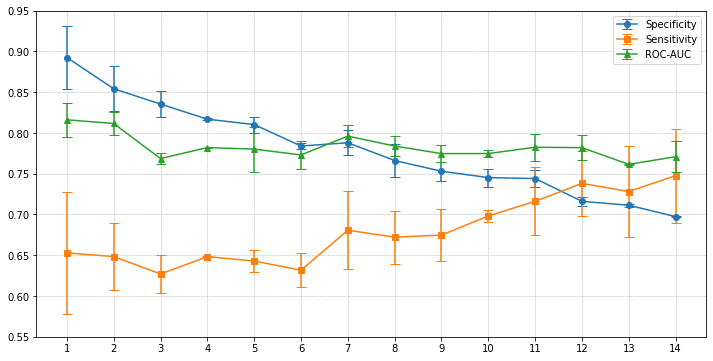

In [8]:
utils_interpretability.plot1_metrics_over_time(all_metrics, n_time_steps)

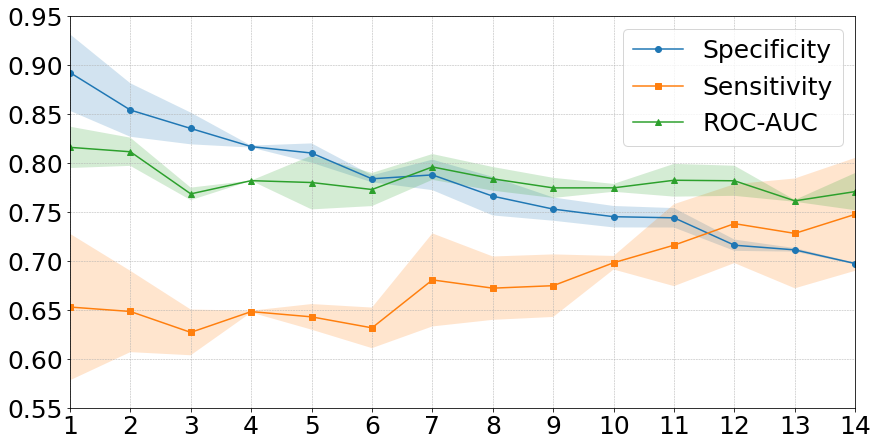

In [9]:
save_img = True
utils_interpretability.plot2_metrics_over_time(all_metrics, n_time_steps, '../Figures_VF/Performance_GRU_Had.pdf', save_img)

## Save results (metrics)

In [10]:
metrics_GRUHad = pd.concat(all_metrics)
metrics_GRUHad.to_csv('./Results_GRU_Had/metrics_GRU_Had.csv', index=False)